## Polytrope EOS inference pipeline

This is an example notebook about how to use our tools to analysis a observation constraint on neutron star equation of state. 

Here in this notebook, we are using a polytrope EoS model (in the future we will implement more equation of state)

In [1]:
import InferenceWorkflow.prior as prior
import InferenceWorkflow.BayesianSampler as sampler
import numpy as np
import ultranest
import ultranest.stepsampler

import EOSgenerators.Polytrope_EOS as Polytrope
from TOVsolver.maxium_central_density import maxium_central_density
from TOVsolver.solver_code import solveTOV
from TOVsolver.unit import g_cm_3, dyn_cm_2, km, Msun, e0, MeV, fm
import TOVsolver.main as main

We need to define the outer crust, this crust and interface is unversial for all the equation of state here, we just change the inner crust part and the core part of equation of state and that is come from the polytrope computation. Crust as below, "Tolos_crust_out.txt" is BPS crust model.

In [2]:
#Tolos_crust_out = np.loadtxt('Tolos_crust_out.txt', delimiter='  ')
Tolos_crust_out = np.loadtxt('Tolos_crust_out.txt', delimiter=None, comments='#', usecols=(0, 1, 2, 3, 4))
eps_crust_T = Tolos_crust_out[:,3] 
pres_crust_T = Tolos_crust_out[:,4]

# eps_crust is the density array from inner crust to core, is the palce where we want to establish the polytrope EoS
# xs_polytro is the central density range of a neutron star

xs_polytro = np.logspace(11.7, 14.28, num=1000, base=10)

ys_polytropic = (4.75764e29 + 9.04238e13 *xs_polytro**(4/3))
xs_polytropic = xs_polytro

eps_crust = np.append(eps_crust_T, xs_polytropic)
pres_crust = np.append(pres_crust_T, ys_polytropic)

# rho_crust_end and P_crust_end are the end of outer crust EoS and the start point of polytrope EoS
rho_crust_end = eps_crust[-1]
P_crust_end = pres_crust[-1]

rho_ns = 267994004080000.03
c = 3e10
G = 6.67428e-8

### Set up prior

Next step, we need to set up the prior, first use parameters array to specify the variable name, should be consistent with what you need to call them. Second, we need to define a list to store some intermediate parameters derived from `prior_transform`. These parameters may be used in `likelihood_transform` or somewhere else and it will be stored in the final result, specifically 'd_max' in this case.
    
Define a prior transform function to define prior. Cube are set of random number from 0 to 1. This prior setting is standard set-up of UltraNest package, since we are using `UltraNest` to do nest-sampling. We provided 

`normal_Prior` and `flat_prior`

two options call from prior. Here then the Parameters prior should all set

------------------

However, since we are doing Equation of state Inference from mass radius of neutron star measurement. The center density of the star should be also sampled. Otherwise will be a partially-defined prior, did not span all parameters space, and proved to be different with full-scope inference.

This request as randomly generate a density from a EoS range, however, this process is not that trivial, since we need to determine the upper limit of the central density of neutron star ---  different equation of state will predict different upper bound, so here we need to use the prior-setting EoS parameters computing the EOS by

```sh
Polytrope.eos_core_pp
```

Compute out EOS, and find out Mass Radius of this equation of state, find out the last stable point of this equation of state.(first mass points that give the direvative to be negative)

In [6]:
parameters = ['rho_t_1', 'rho_t_2', 'gamma_1', 'gamma_2', 'gamma_3', 'd1']
# for two or more MR measurements, define d2 or more depend on complexity.

#derived_param_names = ['d_max']??

gamma_low_limits = [1, 0, 0.5]
gamma_up_limits = [4.5, 8, 8]
def prior_transform(cube):
    para = cube.copy()

    # Output appropriate gamma
    # When we randomly scatter a gamma at one segement, its maxium value is constrained by the start point's pressure, density,
    # and the end point's density. Therefore in each segement, we need call 'fun_gamma_max' to get a sutiable range of gamma.
    para[0] = prior.flat_prior(1.5*rho_ns,8.3*rho_ns, cube[0])
    para[1] = prior.flat_prior(para[0], 8.3*rho_ns, cube[1])
    gammas = []

    for i in range(3):
        para[2+i] = prior.flat_prior(gamma_low_limits[i], gamma_up_limits[i], cube[2+i])

    gammas = np.array([para[2],para[3],para[4]])
    rho_ts= np.array([para[0],para[1]]) * g_cm_3

    density = np.logspace(14.28, 15.6, 1000)
    pres = np.zeros(len(density))
    index = Polytrope.eos_core_pp(gammas, rho_ts, rho_crust_end, density[0], P_crust_end)/P_crust_end/P_crust_end
    for i in range(len(density)):
        pres[i] = Polytrope.eos_core_pp(gammas, rho_ts, rho_crust_end, density[i], P_crust_end)/P_crust_end/index
    
    eps_total = np.array([*eps_crust, *density[1::]])
    pres_total = np.array([*pres_crust, *pres[1::]])
    
    RFSU2R = []
    MFSU2R = []
    density = np.logspace(14.3, 15.6, 50)
    if all(x<y for x,y in zip(eps_total[:], eps_total[1:])) and all(x<y for x, y in zip(pres_total[:], pres_total[1:])):
        MR = main.OutputMR('', eps_total * g_cm_3, pres_total * dyn_cm_2).T
        if len(MR[0]) == False:
            para[5] = 0
            #para[6] = 0
            # this line for showing how to add one more observation
        else:

            for i in range(len(MR[0])):
                RFSU2R.append(MR[1][i])
                MFSU2R.append(MR[0][i])
                if i > 20 and MR[0][i] - MR[0][i-1]< 0:
                    break
    if len(MFSU2R)==False:
        para[5] = 0
        #para[6] = 0
        # this line for showing how to add one more observation
    else:
        max_index = len(MFSU2R)
        max_d = np.log10(density[max_index-1])
        para[5] = 14.3 + (max_d - 14.3) * cube[5]
        #para[6] = 14.3 + (max_d - 14.3) * cube[6]
        # this line for showing how to add one more observation
    return para


### Set up likelihood

We need to set up a likelihood, Using standard definition way of UltraNest, that is below.

Here the likelihood is generated from a simulated mass radius measurement, which is $M = 1.97, 1.44, 2.07$ $M_{\odot}$ and $R = 10, 13, 12$ km, With a 5% Mass radius measurement uncertainty, so here 

   ```sh
   likelihood.MRlikihood_Gaussian
   ```
function will be use for our likelihood, please check [likelihood.MRlikihood_Gaussian](https://github.com/ChunHuangPhy/EoS_inference/blob/main/InferenceWorkflow/Likelihood.py) to see the original code, and more choice of likelihood.
eg:
1. If we have some real mass-radius measurements, say PSR J0030 or PSR J0740, come from NICER, a KDE kernel could be trained to feed into 

   ```sh
   likelihood.MRlikihood_kernel(eps_total,pres_total,x,d1)
   ```
set the KDE kernel as a input for this function

2. If we gain measurement from radio-timing, say only measure the neutron star mass, then

   ```sh
   likelihood.Masslikihood_Gaussian(eps_total,pres_total,x,d1)
   ```
Which will give the likelihood from single mass measurement, x is the parameters of that measurement, you should specify where this measurement mass is located and what is the sigma width of this mass measurement

In [7]:
import pandas as pd
from scipy.interpolate import interp1d
import InferenceWorkflow.Likelihood as likelihood

datas = [
    [10, 1.97, 0.5, 0.0985]
]
datas = pd.DataFrame(datas, index=[1], columns=['R', 'M', 'Rsigma', 'Msigma'])
# add more rows for extra observations and don's forget to add numbers to the index!

Rvalue = datas['R'].values
Mvalue = datas['M'].values

R_sigma = datas['Rsigma'].values
M_sigma = datas['Msigma'].values

def likelihood_transform(theta):
    gammas = np.array([theta[2],theta[3],theta[4]])
    rho_ts = np.array([theta[0],theta[1]]) * g_cm_3
    d1 = theta[5]

    density = np.logspace(14.28, 15.6, 1000)
    pres = np.zeros(len(density))
    index = Polytrope.eos_core_pp(gammas, rho_ts, rho_crust_end, density[0], P_crust_end)/P_crust_end/P_crust_end
    for i in range(len(density)):
        pres[i] = Polytrope.eos_core_pp(gammas, rho_ts, rho_crust_end, density[i], P_crust_end)/P_crust_end/index

    eps_total = np.array([*eps_crust, *density[1::]])
    pres_total = np.array([*pres_crust, *pres[1::]])

    #1. This line is to compute MR likelihood from a Simulated MR measurement:
    
    probMRgaussian1 = likelihood.MRlikihood_Gaussian(eps_total * g_cm_3,pres_total * dyn_cm_2,(Mvalue[0],Rvalue[0],M_sigma[0],R_sigma[0]),d1)
    #probMRgaussian2 = likelihood.MRlikihood_Gaussian(eps_total,pres_total,(Mvalue[1]/Msun,Rvalue[1]/km,M_sigma[1]/Msun,R_sigma[1]/km),d2)

    #2. This is  a block that constrain from given real MR measurement, say J0030:
    #J0030 = numpy.loadtxt('data/PST_equal_sampled_MR.txt', delimiter=' ')
    #J30R_list, J30M_list = zip(*J0030)
    #J30R_list = numpy.array(J30R_list).T    
    #J30M_list = numpy.array(J30M_list).T
    #Rmin = J30R_list.min()
    #Rmax = J30R_list.max()
    #Mmin = J30M_list.min()
    #Mmax = J30M_list.max()
    #X3, Y3 = numpy.mgrid[Rmin:Rmax:500j, Mmin:Mmax:100j]
    #positions = numpy.vstack([X3.ravel(), Y3.ravel()])
    #values = numpy.vstack([J30R_list, J30M_list])
    #kernel3 = stats.gaussian_kde(values)
    #probMRJ0030 = likelihood.MRlikelihhood_kernel(eps_total,pres_total,kernel3,d1)
    
    #3. This is to compute the constraint from experiment of nuclearmatter
    # 250<K<400, 25<J<38, 30<L<86:
    # hint: since this K,J,L sampling don't need to sample central density so this 
    # theta should be redifined.
    #probK = likelihood.Kliklihood(theta,250,400)
    #probJ = likelihood.Jliklihood(theta,250,400)
    #probL = likelihood.Lliklihood(theta,250,400)
    
    #4. This is block to cosntrain from a GW event, say GW170817, here the file of this
    # event is origanized by [chrip mass, M2/M1, tidal of M1, tidal of M2, sampling weight]:
    #GW170817 = np.load('GW170817_McQL1L2weights.npy')
    #chrip170817 = stats.gaussian_kde(GW170817[:,0],weights = GW170817[:,4])
    #kernelGW = stats.gaussian_kde(GW170817.T[0:4],weights = GW170817[:,4])
    #probGW = likelihood.TidalLikihood_kernel(eps_total,pres_total,(kernelGW,chrip170817),d1)


    #5. This block constraints pure neutron matter EOS
    ## For pure neutron matter alpha = 0
    #theta1    = np.append(theta, 0)
    #rho, e, p = RMF.get_eos_alpha(theta1)
    #EoS_PNM   = np.array([rho, e*oneoverfm_MeV, p*oneoverfm_MeV]) # energy density and pressure are converted from fm^-4 to MeV fm^-3
 
    #probPNM = likelihood.chiEFT_PNM(EoS_PNM, type="Super Gaussian", contraint_quantity="e", enlargement=0.1) # 10% enlargement 
    
    prob =  probMRgaussian1 #+ probMRgaussian2 + probMRJ0030 + probK + probJ + probL + probGW + probPNM


    return prob

The code below could be used to check out if we set the prior in correct unit.

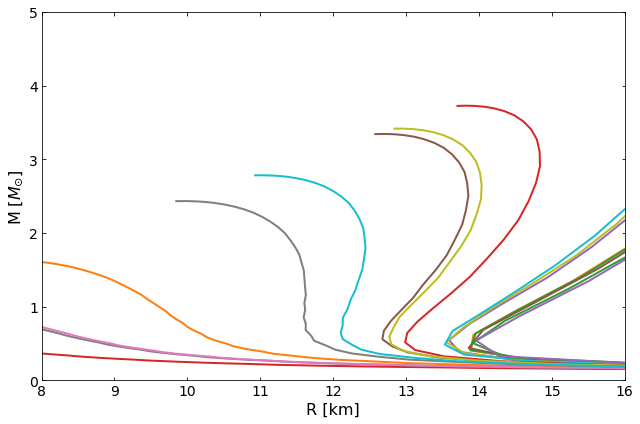

In [3]:
import matplotlib.pyplot as plt
import random

gamma_low_limits = [1, 0, 0.5]
gamma_up_limits = [4.5, 8, 8]
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
for j in range(20):
    para = [0]*7
    para[0] = prior.flat_prior(1.5*rho_ns,8.3*rho_ns, random.uniform(0, 1))
    para[1] = prior.flat_prior(para[0], 8.3*rho_ns, random.uniform(0, 1))
    #para[2] = prior.flat_prior(para[1], 8.3*rho_ns, random.uniform(0, 1))
    rhots = [para[0], para[1], xs_polytro[-1]]
    gammas = []
    k = 0
    pt = 0
    for i in range(3):
        para[2+i] = prior.flat_prior(gamma_low_limits[i], gamma_up_limits[i], random.uniform(0,1))

    gammas = np.array([para[2],para[3],para[4]])
    rho_ts= np.array([para[0],para[1]])* g_cm_3
    
    density = np.logspace(14.28, 15.6, 1000)
    pres = np.zeros(len(density))
    index = Polytrope.eos_core_pp(gammas, rho_ts, rho_crust_end, density[0], P_crust_end)/P_crust_end/P_crust_end
    for i in range(len(density)):
        pres[i] = Polytrope.eos_core_pp(gammas, rho_ts, rho_crust_end, density[i], P_crust_end)/P_crust_end/index

    eps_total = np.array([*eps_crust, *density[1::]])
    pres_total = np.array([*pres_crust, *pres[1::]])
    
    


    RFSU2R = []
    MFSU2R = []
    density = np.logspace(14.28, 15.6, 50)
    if all(x<y for x,y in zip(eps_total[:], eps_total[1:])) and all(x<y for x, y in zip(pres_total[:], pres_total[1:])):
        MR = main.OutputMR('', eps_total*g_cm_3, pres_total* dyn_cm_2).T
        if len(MR[0]) == False:
            para[7] = 0
            #para[8] = 0
            # this line for showing how to add one more observation
        else:

            for i in range(len(MR[0])):
                RFSU2R.append(MR[1][i])
                MFSU2R.append(MR[0][i])
                if i > 20 and MR[0][i] - MR[0][i-1]< 0:
                    break

    RFSU2R = np.array(RFSU2R)
    MFSU2R = np.array(MFSU2R)


    ax.plot(RFSU2R/km , MFSU2R/Msun, lw=2)
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
ax.set_xlim(8.0, 16.0)
ax.set_ylim(0, 5)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
fig.tight_layout()
plt.show()

### Set up sampler

Here next, we define sampler.

Some of the sampler parameters is requested, first is step number, our choice for UltraNest sampler is slicesampler, which could easily be sliced up your total computation load, and parallelize, speed up sampling. So step as suggested by documentation of UltraNest, we use 2*len(parameters).

live_point we set 400, it will influence the sampling precision, We suggest for 10 dimension space, maybe 5000 is a better choice, however, since my computer only have limited resources, we set 400.

max_calls set 500000, it is how many iteration after it will stop, we suggest to set this number significantly higher, maybe 5000000, otherwise maybe will broken before the inference converging to a definite value. That result will be un-phyiscal.

derived_param_names is calculated from prior_transform and is the intermediate quantity necessary for calculating likelihood_transform. It will not be involved in the inference process.


In [ ]:
step = 2 * len(parameters)
live_point = 400

max_calls = 60000
samples = sampler.UltranestSampler(parameters,likelihood_transform,prior_transform,step,live_point,max_calls)